## Neural network classification w/ PyTorch
https://youtu.be/V_xro1bcAuA?si=Om1cqgkY8RUoBjIf&t=30808

* Classification - predicting a label
* Regression - predicting a number

### Architecture of a classification model
* Input layer shape
* Hidden layer(s)
* Neurons per hidden layer
* Output layer shape (out_features)
* Hidden layer activation
* Output activation
* Loss function
* Optimizer

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready 

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42) # 'X' is the data (matrix) and 'y' is the label

In [2]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


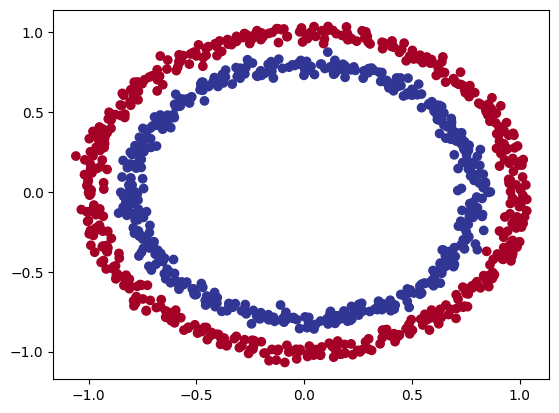

In [4]:
# Visualize, visualize, visualize...
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referring to as a toy dataset, a dataset that is small enough to experiment on but sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train/test splits

In [7]:
import torch
torch.__version__

'2.9.0+cu126'

In [8]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
torch.manual_seed(42) # only affects PyTorch code

In [21]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # test size is 20%, train is 80%

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU - if there is one)
2. Construct a model (by sublcassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop 

In [14]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    !nvidia-smi

Mon Jan 19 20:59:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Now we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass nn.Module)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [15]:
X_train.shape

torch.Size([800, 2])

In [23]:
y_train[:5]

array([1, 0, 0, 0, 1])

In [17]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # refer to X_train shape, in features is the # of elements of each dimension, out_features is # of linear layers
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # in_features of this layer must be the same as the out_feature of previous layer

        # Another way adding linear layers
        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    # 3. Define a forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
        
        # return two_linear_layers(x)


# 4. Instantiate instance of model class and send to target device
model_0 = CircleModelV1().to(device)
model_0


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [19]:
# Let's replicate the model above using nn.Sequential(), similar to previous model because data is being processed to each layer in order (in sequence)
# BUT subclasses offer more custom changes
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [21]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function and optimizer should you use? (for classification in this case)

* For example regression is for predicting a number - MAE or MSE would be good
* For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options

* For the loss function, we're going to use `torch.nn.BECWithLogitsLoss()` - binary cross entropy
* What are logits???

In [22]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss - requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss - has sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [23]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we've going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero gradient
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model ooutputs are going to be raw **logits**.

So we can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probability to **prediction labels** by either rounding them or taking the `argmax()`

In [24]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [25]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probabiliity values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, y = 1 (class 1)
* `y_pred_probs` < 0.5, y= 0 (class 0)

In [26]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epchs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.to(device)
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as inputs
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing 
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Acc: 51.88% | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Acc: 51.25% | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Acc: 51.62% | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Acc: 51.12% | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Acc: 50.88% | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Acc: 50.25% | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Acc: 50.00% | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Acc: 50.25% | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Acc: 49.88% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Acc: 49.88% | Test loss: 0.69262, Test acc: 53.00%
Epoch: 100 | Loss: 0.69331, Acc: 49.25% | Test loss: 0.69271, Test acc: 53.00%
Epoch: 110 | Loss: 0.69327, Acc: 49.75% | Test loss: 0.69279, Test acc: 54.00%
Epoch: 120 | Loss: 0.69324, Acc: 50.25% | Test loss: 0.69286, T

## 4. Make predictions and evaluate the model
After 100 epochs, the model is not learning and is good as guessing :(. Let's inspect his by making predictions and visualizing them!

To do so, we're going to import a function called `plot_descision_boundary()`


In [28]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


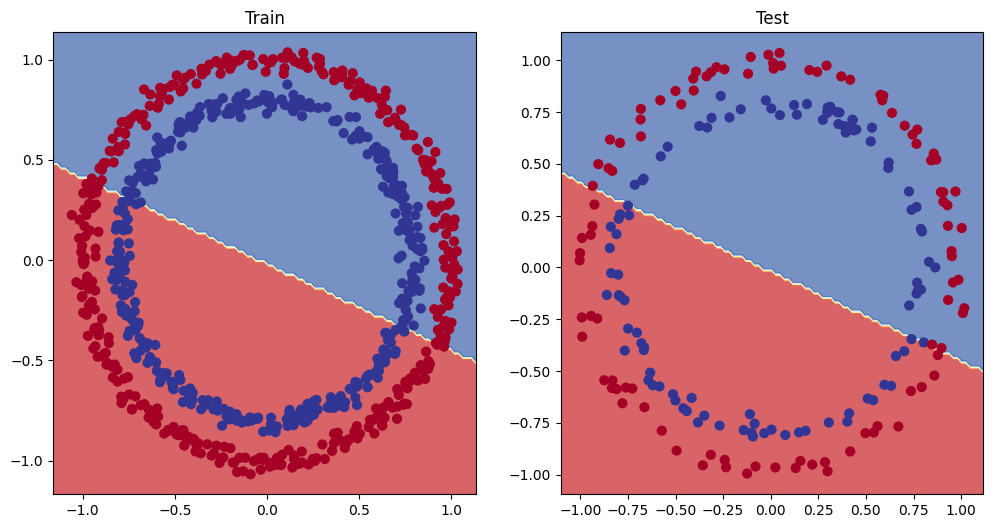

In [29]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)
After another 1000 epochs the model has actually gotten worse. There is a slight decrease in loss, which is nice, but its very little. Accuracy also decreased by about 10%.

How to improve then?
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - out_features, from 5 to 10 hidden units
* Fit for longer - increase epoch (training loops)
* Changing the activation functions - put activation functions within the model??
* Change learning rate - lr, exploding gradient problem?
* Change the loss function

These options are all from a model's perspective because they deal directly with the model rather than the data.

And because these options are all values we (as machiine learning enginers and data scientists) can change, they are referred to **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [30]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [32]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred prob -> pred labels

    # 2. Calcuate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


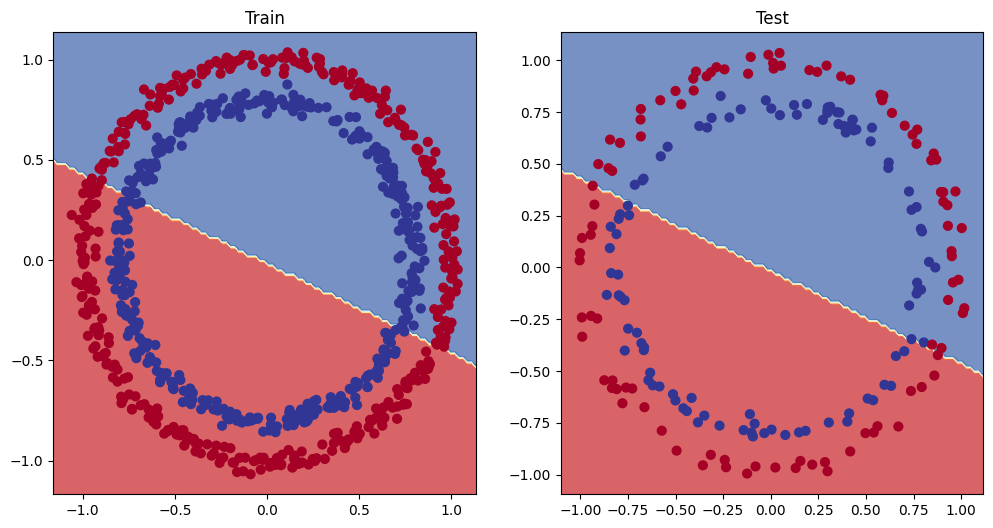

In [33]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem.

In [34]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [35]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

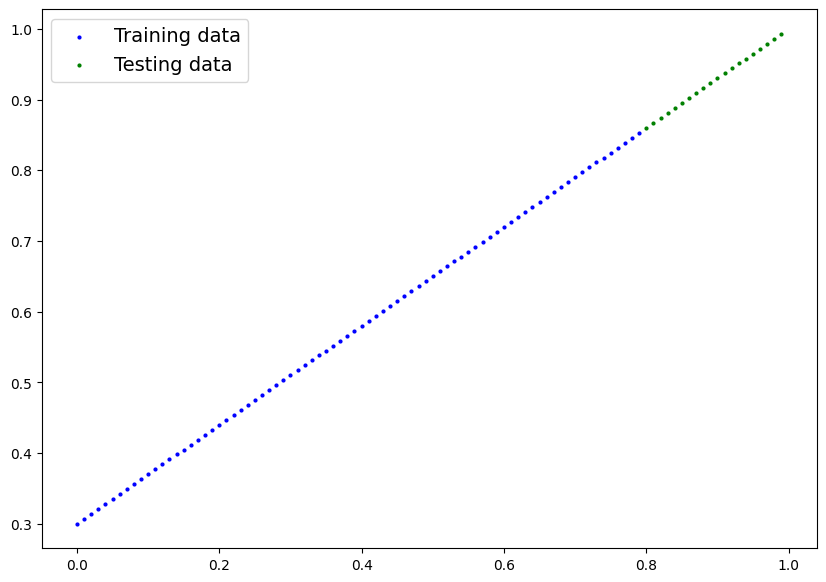

In [36]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

###  5.2 Adjusting `model_1` to fit a straight line

In [37]:
# Same architecture as model_1 (but using nn.Sequential)

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Create loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [39]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    # Set model to train
    model_2.train()

    # Forward pass
    y_pred = model_2(X_train_regression)
    
    # Calculate the loss
    loss = loss_fn(y_pred, y_train_regression)

    # Optimize zero grad
    optimizer.zero_grad()

    # Backward loss
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


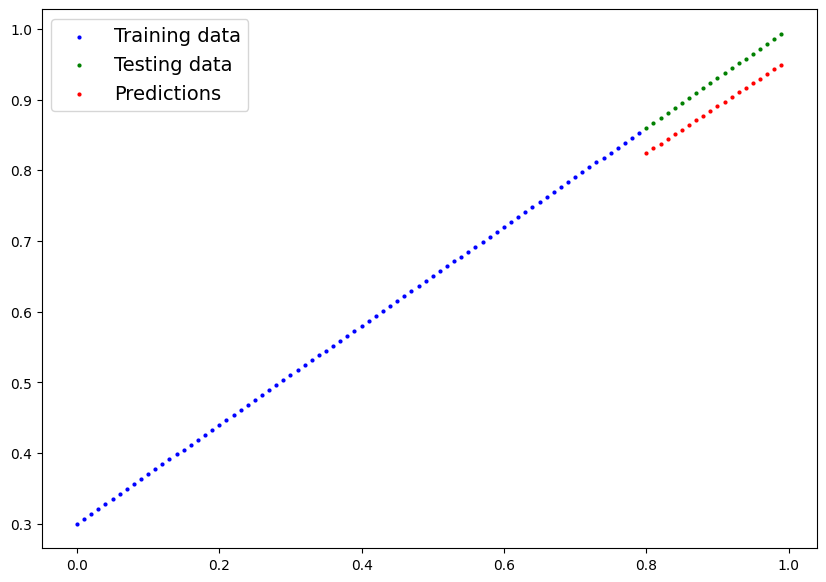

In [40]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(), test_data=X_test_regression.cpu(), test_labels=y_test_regression.cpu(), predictions=y_preds.cpu())

### 6. The missing piece: non-linearity
Looks like our circle model does learn for linear data but why not for our circular data???

"What patterns could you draw if you given a infinite amount of a straight and non-straight lines?

Or in machine learning terms, an infinite (but really hit is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

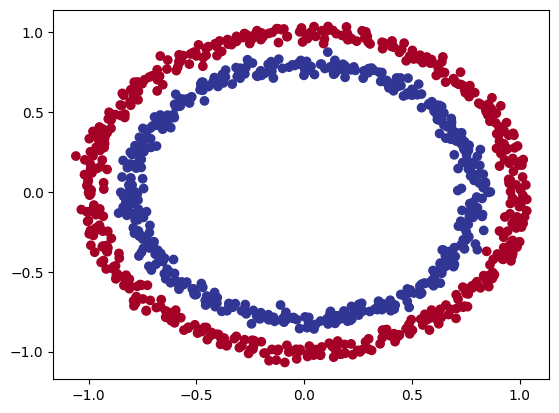

In [41]:
# Make and plot data
import matplotlib.pyplot as plot
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [42]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
* Linear - straight lines
* Non-linear = non-straight lines

In [43]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Where should we put our non-linear activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred prob -> pred labels

    # 2. Calcuate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test acc: 79.00%
Epoch: 1000 | Loss: 0.56818, Acc: 87.75% | Test loss: 0.57378, Test acc: 86.50%
Epoch: 1100 | Loss: 0.48153, Acc: 93.50% | Test loss: 0.49935, Test acc: 90.50%
Epoch: 1200 | Loss: 0.37056, Acc: 97.75% | Test loss

### 6.4 Evaluating a model trained with non-linear activation functions

In [46]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

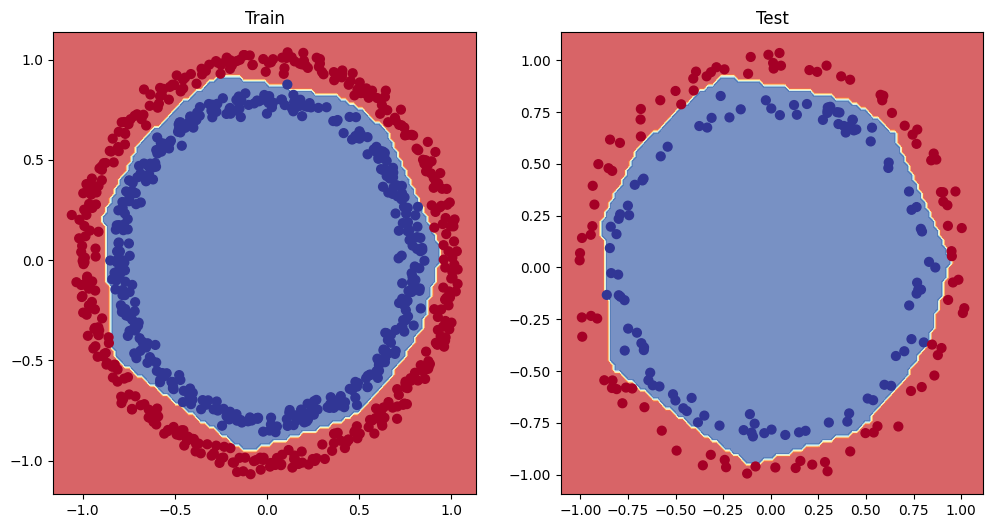

In [47]:
# Plot the decision boundary - look at the improvement!!! (This is the power of non-linearity)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

We improved our model by training it through 2000 epochs!

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.


In [48]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float)
A.dtype

torch.float32

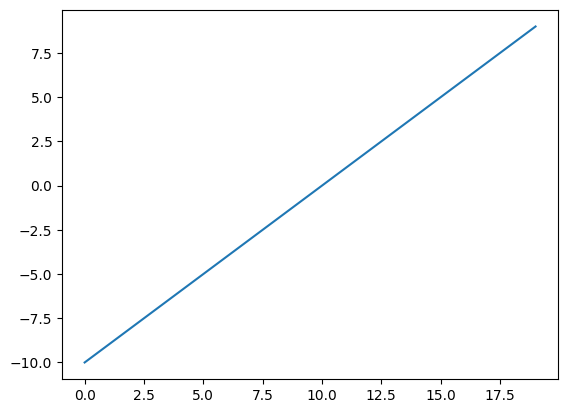

In [49]:
# Visualizez the tensor
plot.plot(A)

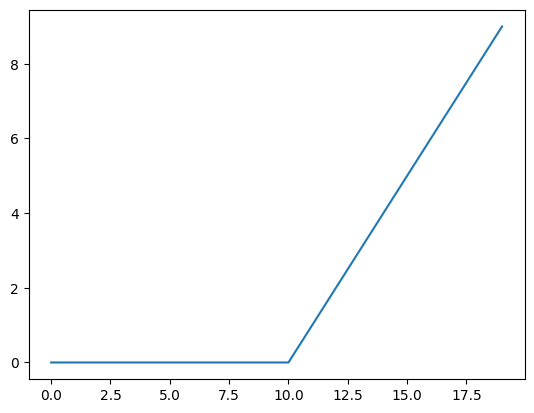

In [50]:
plt.plot(torch.relu(A))

In [51]:
# This is how nn.ReLU works
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

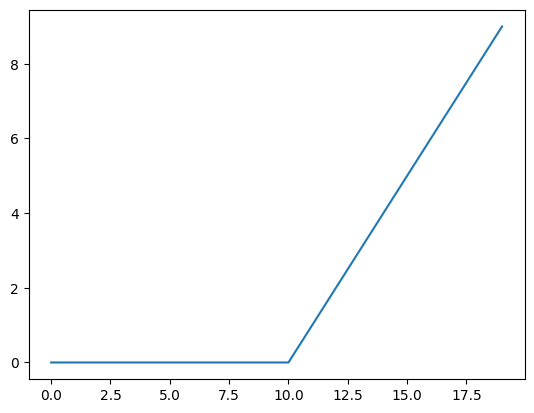

In [52]:
plt.plot(relu(A)) # as you can see here...

In [55]:
# Now let's do the same for sigmoid
def sigmoid(x : torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

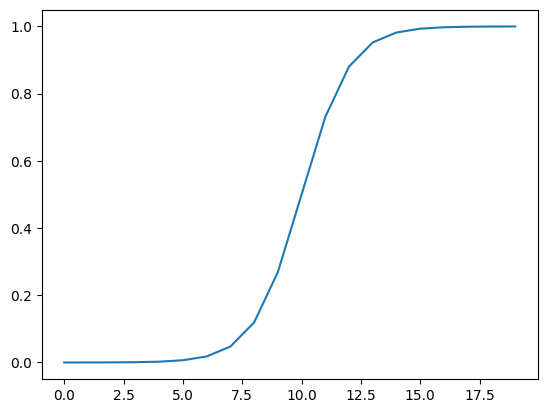

In [53]:
plt.plot(torch.sigmoid(A))

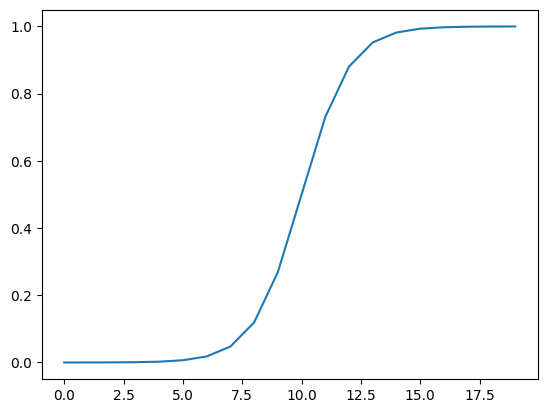

In [56]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-classification problem
* Binary classification - true/false, spam or not spam, cat or dog, yes or no
* Multi-class classification - dog, cat, or chicken? yes, no, maybe?


### 8.1 Creating a toy multi-class dataset

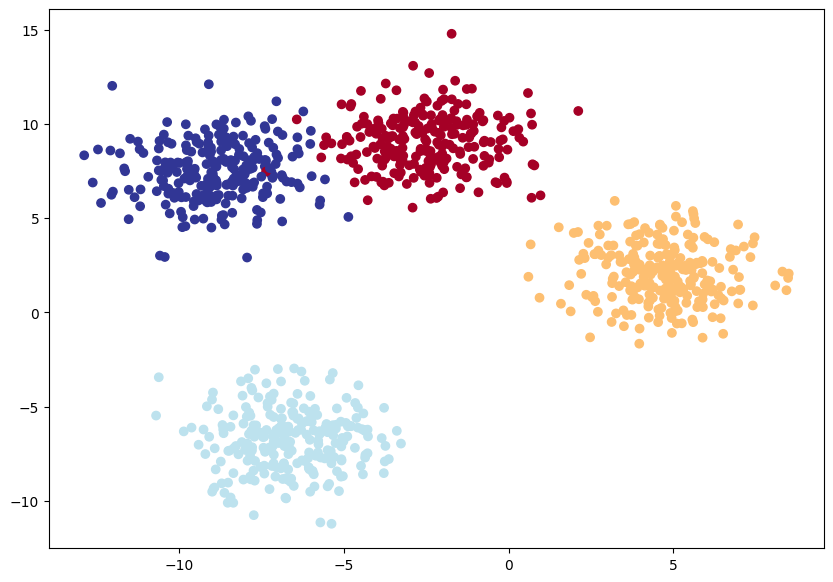

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES, 
                            centers=NUM_CLASSES, 
                            cluster_std=1.5, # give the clusters some randomness
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data (visualize, visualize, visualize...)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [2]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model.
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of outputs features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8

        Returns:
            pass

        Example:
            pass
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    # Do we need non-linearity? such as nn.ReLU?
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [4]:
X_blob_train[:10], y_blob_train[:10]

# output features value is 4 for this data
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [5]:
# Create loss function and optimizer for multi-class classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 8.4 Getting prediction probabilities for a multi-class PyTorch model
In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw ouput of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [6]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.4515, -0.4939, -0.0411,  0.1457],
        [-0.1981, -0.2822, -0.2498, -0.0951],
        [-0.0843,  0.0493, -0.1347, -0.1319],
        [-0.2009, -0.3230, -0.0225,  0.0335],
        [-0.6406, -0.6934, -0.4548,  0.2268],
        [-0.2105, -0.2779, -0.2642, -0.0997],
        [-0.1375,  0.0479, -0.2279, -0.0909],
        [-0.5015, -0.5760, -0.3864,  0.1344],
        [-0.0134,  0.0648,  0.0020, -0.1950],
        [-0.5443, -0.6093, -0.4065,  0.1622]], device='cuda:0')

In [7]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [8]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5]) # sum of element in each row equals to 1??

tensor([[-0.4515, -0.4939, -0.0411,  0.1457],
        [-0.1981, -0.2822, -0.2498, -0.0951],
        [-0.0843,  0.0493, -0.1347, -0.1319],
        [-0.2009, -0.3230, -0.0225,  0.0335],
        [-0.6406, -0.6934, -0.4548,  0.2268]], device='cuda:0')
tensor([[0.1893, 0.1814, 0.2853, 0.3439],
        [0.2514, 0.2311, 0.2388, 0.2787],
        [0.2471, 0.2824, 0.2349, 0.2356],
        [0.2302, 0.2037, 0.2751, 0.2910],
        [0.1807, 0.1714, 0.2176, 0.4302]], device='cuda:0')


In [9]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [10]:
torch.max(y_pred_probs[0])

tensor(0.3439, device='cuda:0')

In [11]:
torch.argmax(y_pred_probs[0])

tensor(3, device='cuda:0')

In [12]:
# Convert our model's prediction probabilites to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1,
        1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3,
        3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1,
        1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
        1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3,
        1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3,
        3, 3, 1, 3, 3, 3, 1, 3], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [13]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Move data to device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Set number of epochs
epochs = 100

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train) # logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # to prediction probabilities (softmax) to prediction labels (argmax)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing and eval
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds) ##

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.49, Acc: 20.00% | Test Loss: 1.3812, Test Acc: 39.50%
Epoch: 10 | Loss: 0.82, Acc: 84.62% | Test Loss: 0.7554, Test Acc: 80.50%
Epoch: 20 | Loss: 0.38, Acc: 97.75% | Test Loss: 0.3700, Test Acc: 98.00%
Epoch: 30 | Loss: 0.19, Acc: 99.12% | Test Loss: 0.1801, Test Acc: 99.50%
Epoch: 40 | Loss: 0.10, Acc: 99.25% | Test Loss: 0.0961, Test Acc: 99.50%
Epoch: 50 | Loss: 0.07, Acc: 99.12% | Test Loss: 0.0638, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05, Acc: 99.12% | Test Loss: 0.0485, Test Acc: 99.50%
Epoch: 70 | Loss: 0.05, Acc: 99.12% | Test Loss: 0.0399, Test Acc: 99.50%
Epoch: 80 | Loss: 0.04, Acc: 99.12% | Test Loss: 0.0345, Test Acc: 99.50%
Epoch: 90 | Loss: 0.04, Acc: 99.12% | Test Loss: 0.0307, Test Acc: 99.50%


### 8.6 Making and evaluating precitions with a PyTorch multi-class model

In [14]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 1.1147,  7.3736, -0.6918, -3.3418],
        [-0.6753, -3.2182, -5.2031,  4.0274],
        [ 0.1179, -0.8551,  7.2261, -6.0983],
        [-0.0153,  5.2595, -0.5350, -1.8200],
        [ 5.7691,  0.2498, -3.8598, -2.6062],
        [-1.1551, -3.8075, -5.9319,  4.9144],
        [ 0.0932, -0.8427,  7.0148, -5.9489],
        [ 4.8937, -1.5990, -3.9868, -1.1674],
        [ 0.1927, -0.9704,  7.7136, -6.5684],
        [ 5.4003, -1.0121, -3.8623, -1.8510]], device='cuda:0')

In [15]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs

tensor([[1.9092e-03, 9.9776e-01, 3.1354e-04, 2.2150e-05],
        [8.9818e-03, 7.0627e-04, 9.7039e-05, 9.9021e-01],
        [8.1748e-04, 3.0895e-04, 9.9887e-01, 1.6322e-06],
        [5.0736e-03, 9.9107e-01, 3.0172e-03, 8.3472e-04],
        [9.9571e-01, 3.9913e-03, 6.5518e-05, 2.2950e-04],
        [2.3067e-03, 1.6257e-04, 1.9428e-05, 9.9751e-01],
        [9.8484e-04, 3.8630e-04, 9.9863e-01, 2.3406e-06],
        [9.9603e-01, 1.5083e-03, 1.3852e-04, 2.3226e-03],
        [5.4131e-04, 1.6916e-04, 9.9929e-01, 6.2677e-07],
        [9.9756e-01, 1.6370e-03, 9.4675e-05, 7.0750e-04],
        [9.7458e-01, 3.2645e-03, 4.0509e-04, 2.1748e-02],
        [5.1134e-04, 9.9940e-01, 8.0637e-05, 4.3686e-06],
        [9.9845e-01, 1.2572e-03, 4.2792e-05, 2.5087e-04],
        [9.9892e-01, 5.5933e-04, 3.0924e-05, 4.8971e-04],
        [9.9947e-01, 3.5029e-04, 1.2677e-05, 1.6452e-04],
        [5.1092e-02, 1.8775e-03, 3.1749e-04, 9.4671e-01],
        [6.2756e-03, 5.6813e-04, 8.1382e-05, 9.9307e-01],
        [2.041

In [16]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [17]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [18]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


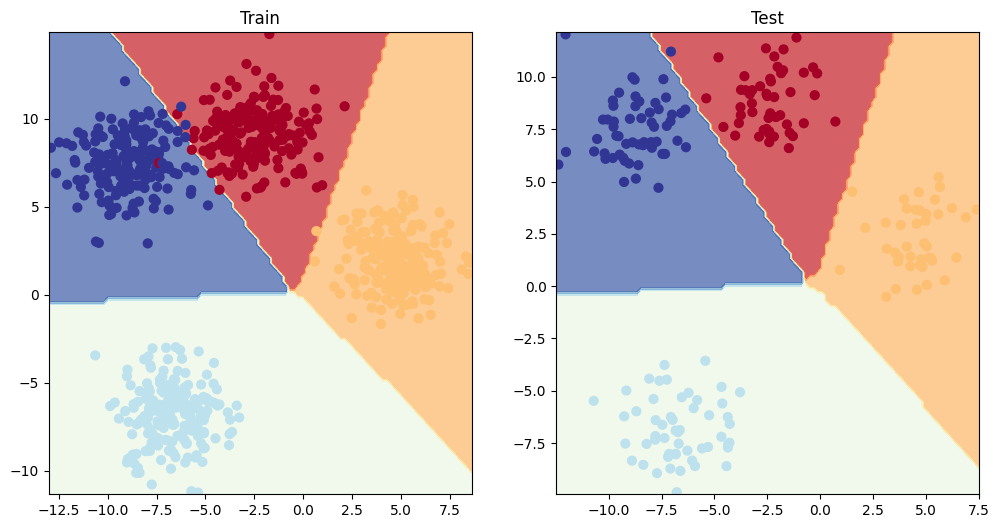

In [19]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### Observation - In this scenario non-linear layers was not necessary as the model can perform well without them. In most scenarios though, non-linearity will most likely be needed.

## 9. A few more classification metrics... (to evaluate our classification model)

Look into torch.metrics or sklearn.metrics

* Accuracy - out of 100 samples, how many does our model get right?, good for balanced data (equal/similar sample size in each group)
* Precision - overall needed
* Recall - overall needed
* F1-score - combines precision and recall
* Confusion matrix
* Classification report - sklearn.metrics

Article for when to use precision and recall: https://medium.com/data-science/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics

In [20]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 66.7 MB/s eta 0:00:00


In [23]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

## Exercises & Extra-curriculum
See exercises and extra-curriculum here: https://www.learnpytorch.io/02_pytorch_classification/#exercises

In [1]:
import sklearn
from sklearn.datasets import make_moons

# Number of samples
n_samples = 1000

# Create moons
X, y = make_moons(n_samples, noise=0.03, random_state=42)

In [2]:
# View data
X[:5], y[:5] # as observed, X has two dimensions and y is just a scalar (array or single dimension tensor - later on)

(array([[-0.00933187,  0.39098105],
        [ 0.95457387, -0.47375583],
        [ 0.9185256 , -0.42519648],
        [ 0.41276802, -0.37638459],
        [-0.84532016,  0.52879908]]),
 array([1, 1, 1, 1, 0]))

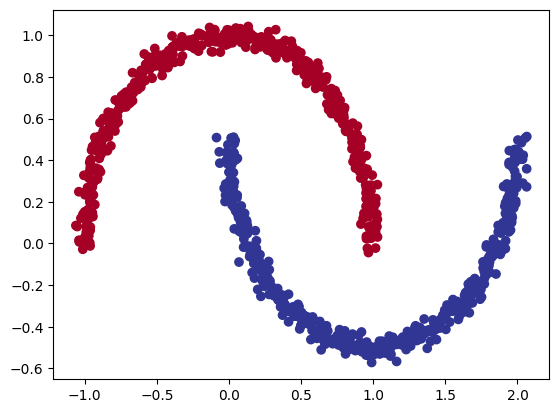

In [3]:
# Let's visualize the data
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [4]:
from sklearn.model_selection import train_test_split
import torch

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Separate data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
from torch import nn

# Let's choose and build the model
class MoonModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        """Initializes multi-class classification model.
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of outputs features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8
        """
        self.layers_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.layers_stack(x)

# Create model
model_moon = MoonModel(input_features=2, output_features=1).to(device)
model_moon


MoonModel(
  (layers_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [7]:
# Create loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_moon.parameters(), lr=0.1)

In [8]:
pip install torchmetrics

In [9]:
from torchmetrics import Accuracy
# instantiate Accuracy function
acc_fn = Accuracy(task='Binary', num_classes=2).to(device)

# Training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data into target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 2000
for epoch in range(epochs):
    # Set model to train mode
    model_moon.train()

    # Forward pass
    y_logits = model_moon(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train)

    # Set optimizer zero grad
    optimizer.zero_grad()

    # Backward loss
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Testing and eval
    model_moon.eval()
    with torch.inference_mode():
        # Make predictions for testing
        test_logits = model_moon(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate both loss and accuracy
        test_loss = loss_fn(test_pred, y_test)
        test_acc = acc_fn(test_pred, y_test)

    # Show what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.71013, Acc: 0.50 | Test Loss: 0.81326 | Test Acc: 0.50
Epoch: 10 | Loss: 0.69452, Acc: 0.50 | Test Loss: 0.81326 | Test Acc: 0.50
Epoch: 20 | Loss: 0.68005, Acc: 0.58 | Test Loss: 0.75125 | Test Acc: 0.60
Epoch: 30 | Loss: 0.66430, Acc: 0.84 | Test Loss: 0.58980 | Test Acc: 0.81
Epoch: 40 | Loss: 0.64637, Acc: 0.83 | Test Loss: 0.57279 | Test Acc: 0.82
Epoch: 50 | Loss: 0.62349, Acc: 0.82 | Test Loss: 0.57348 | Test Acc: 0.81
Epoch: 60 | Loss: 0.59459, Acc: 0.82 | Test Loss: 0.57348 | Test Acc: 0.81
Epoch: 70 | Loss: 0.55955, Acc: 0.82 | Test Loss: 0.57709 | Test Acc: 0.81
Epoch: 80 | Loss: 0.51959, Acc: 0.83 | Test Loss: 0.57329 | Test Acc: 0.82
Epoch: 90 | Loss: 0.47600, Acc: 0.83 | Test Loss: 0.58809 | Test Acc: 0.81
Epoch: 100 | Loss: 0.43291, Acc: 0.84 | Test Loss: 0.59739 | Test Acc: 0.79
Epoch: 110 | Loss: 0.39457, Acc: 0.85 | Test Loss: 0.59600 | Test Acc: 0.80
Epoch: 120 | Loss: 0.36304, Acc: 0.85 | Test Loss: 0.59530 | Test Acc: 0.81
Epoch: 130 | Loss: 0.33

In [10]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


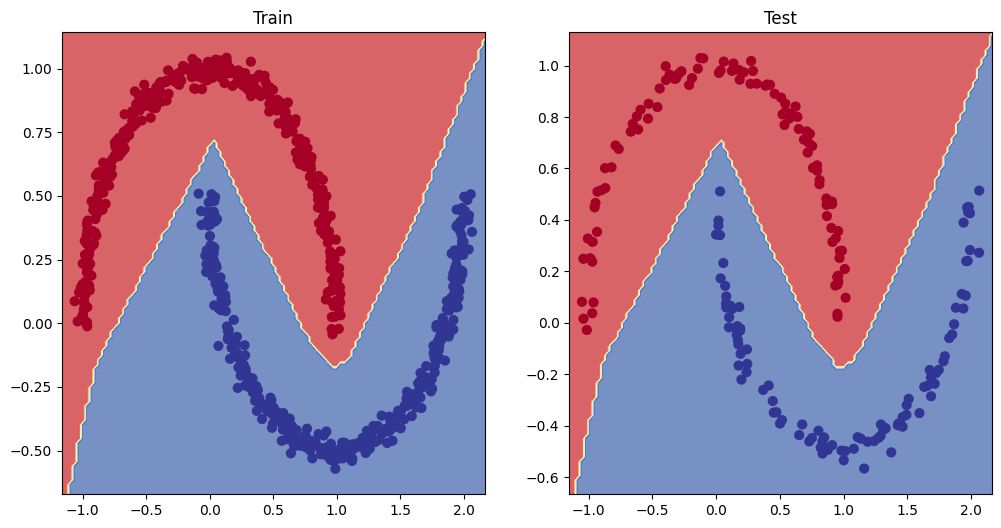

In [11]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_moon, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_moon, X_test, y_test)

In [12]:
# Further quantifiable verification
model_moon.eval()
with torch.inference_mode():
    y_logits_v = model_moon(X_test.cpu())
    y_preds_v = torch.round(torch.sigmoid(y_logits_v))

y_preds_v[:10], y_test[:10]
# They match!

(tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

In [13]:
# Compare nn.Tanh (Pytorch) to custom function
import numpy as np

def tanh(z):
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

m = nn.Tanh()
input = torch.randn(2)
output = m(input)

print(f"Pytorch Tanh: {output}")
print(f"Custom Tanh: {tanh(input)}")
# The same!

Pytorch Tanh: tensor([0.3245, 0.1281])
Custom Tanh: tensor([0.3245, 0.1281])


/tmp/ipython-input-1736255579.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


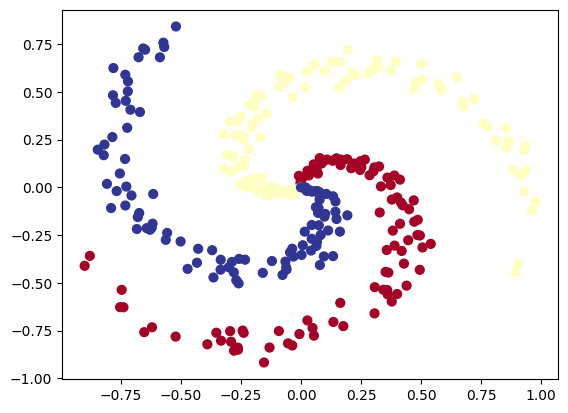

In [14]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [15]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

X_train_spiral, X_test_spiral, y_train_spiral, y_test_spiral = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# There are three categories, this is the number of input features to set for model
torch.unique(y_test_spiral)

tensor([0, 1, 2])

In [17]:
class SpiralModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """ Initializes multi-class classification model.
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of outputs features (number of output classes)
            hidden_units (int): Number of hidden units between layers, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
            )   
    
    # Do we need non-linearity? such as nn.ReLU?
    def forward(self, x):
        return self.linear_layer_stack(x)

model_spiral = SpiralModel(input_features=2, output_features=3).to(device)
model_spiral

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [18]:
# Create loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_spiral.parameters(), lr=0.1)

# Create accuracy function
acc_fn = Accuracy(task='Multiclass', num_classes=3).to(device)

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train_spiral, y_train_spiral = X_train_spiral.to(device), y_train_spiral.to(device)
X_test_spiral, y_test_spiral = X_test_spiral.to(device), y_test_spiral.to(device)

epochs = 100
for epoch in range(epochs):
    model_spiral.train()
    y_logits = model_spiral(X_train_spiral)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_train_spiral)
    acc = acc_fn(y_pred, y_train_spiral)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_spiral.eval()
    with torch.inference_mode():
        test_logits = model_spiral(X_test_spiral)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test_spiral)
        test_acc = acc_fn(test_pred, y_test_spiral)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.08, Acc: 0.35 | Test Loss: 1.0597, Test Acc: 0.25
Epoch: 10 | Loss: 0.87, Acc: 0.53 | Test Loss: 0.9008, Test Acc: 0.53
Epoch: 20 | Loss: 0.68, Acc: 0.61 | Test Loss: 0.7051, Test Acc: 0.57
Epoch: 30 | Loss: 0.48, Acc: 0.73 | Test Loss: 0.5734, Test Acc: 0.70
Epoch: 40 | Loss: 0.41, Acc: 0.77 | Test Loss: 0.5119, Test Acc: 0.73
Epoch: 50 | Loss: 0.35, Acc: 0.84 | Test Loss: 0.4664, Test Acc: 0.67
Epoch: 60 | Loss: 0.25, Acc: 0.90 | Test Loss: 0.2582, Test Acc: 0.90
Epoch: 70 | Loss: 0.15, Acc: 0.95 | Test Loss: 0.0983, Test Acc: 0.95
Epoch: 80 | Loss: 0.11, Acc: 0.95 | Test Loss: 0.0849, Test Acc: 0.97
Epoch: 90 | Loss: 0.09, Acc: 0.96 | Test Loss: 0.0550, Test Acc: 0.98


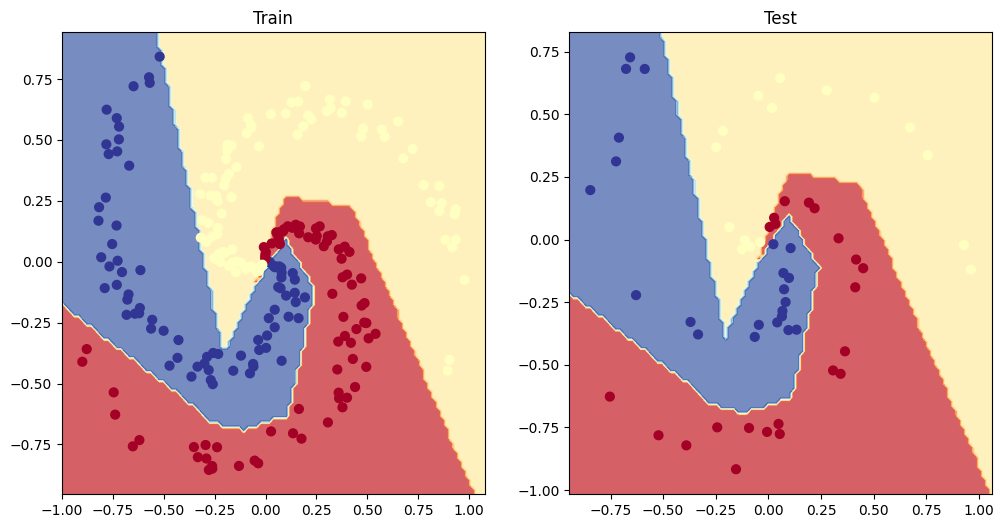

In [21]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_spiral, X_train_spiral, y_train_spiral)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_spiral, X_test_spiral, y_test_spiral)